<div style="text-align: center; background-color: #0A6EBD; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Final project - Introduction to DS
</div>

<div style="text-align: center; background-color: #5A96E3; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  Stage 03 - EDA (Exploratory Data Analysis)
</div>

## Import

In [1]:
import pandas as pd
import numpy as np

# NLP libraries
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read processed data from file

In [2]:
video_df = pd.read_csv("../data/processed/video_data_processed.csv")

video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,hour,day,day_of_week,month,year
0,WkqM0ndr42c,Data School,My top 50 scikit-learn tips,If you already know the basics of scikit-learn...,python|data science|machine learning|scikit-learn,2023-04-20 14:56:43+00:00,8210,355,45,10051,hd,False,14,20,3,4,2023
1,tWFQqaRtSQA,Data School,21 more pandas tricks,You're about to learn 21 tricks that will help...,python|pandas|data analysis|data science,2022-05-12 16:20:41+00:00,43576,1379,67,1480,hd,False,16,12,3,5,2022
2,gd-TZut-oto,Data School,Adapt this pattern to solve many Machine Learn...,Here's a simple pattern that can be adapted to...,python|machine learning|scikit-learn|data science,2021-10-28 16:16:39+00:00,11707,435,16,469,hd,False,16,28,3,10,2021
3,v2QpvCJ1ar8,Data School,Tune multiple models simultaneously with GridS...,You can tune 2+ models using the same grid sea...,python|machine learning|scikit-learn|data science,2021-10-26 13:53:24+00:00,6453,198,14,307,hd,False,13,26,1,10,2021
4,sMlsd2CnIf4,Data School,Access part of a Pipeline using slicing,Want to operate on part of a Pipeline (instead...,python|machine learning|scikit-learn|data science,2021-10-21 14:49:56+00:00,2413,64,4,218,hd,False,14,21,3,10,2021


### Question 01: Is there a correlation between the duration of the videos and the number of views or likes?
  
**Answering this question will** help us understand whether duration has any impact on engagement.
  
**How we answer this question:** : we will calculate the correlation coefficient between the duration and the number of view or likes.

Calculate the correlation between duration and views as well as duration and likes.

In [3]:
duration = video_df['duration']
view_count = video_df['viewCount']
like_count = video_df['likeCount']

# Calculate correlation coefficients
correlation_data = pd.DataFrame({'Duration': duration, 'ViewCount': view_count, 'LikeCount': like_count})

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

correlation_matrix

,Duration,ViewCount,LikeCount
Duration,1.000000,0.099520,0.060441
ViewCount,0.099520,1.000000,0.869915
LikeCount,0.060441,0.869915,1.000000


Plotting duration against viewCount and likeCount

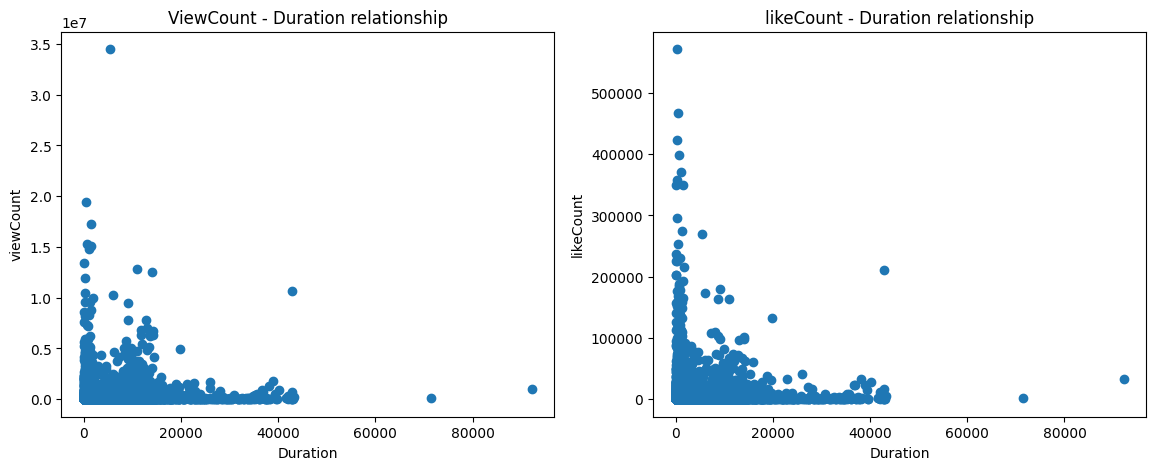

In [4]:
fig = plt.figure(figsize=(14,5))
axs = fig.subplots(1,2).flatten()

axs[0].scatter(y=video_df['viewCount'], x=video_df['duration'])
axs[0].set(title='ViewCount - Duration relationship', ylabel='viewCount', xlabel='Duration')

axs[1].scatter(y=video_df['likeCount'], x=video_df['duration'])
axs[1].set(title='likeCount - Duration relationship', ylabel='likeCount', xlabel='Duration');

Create a heatmap to visualize the correlation coefficient

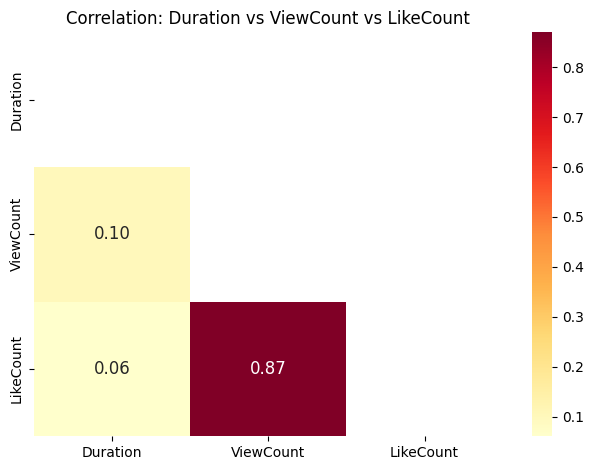

In [5]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='YlOrRd', fmt=".2f", annot_kws={"size": 12})
plt.title('Correlation: Duration vs ViewCount vs LikeCount')

plt.tight_layout()
plt.show()

- `Comment:` The correlation coefficients between the video duration and view count (0.1) and between the duration and like count (0.06) suggest a relatively weak relationship. It appears that **the duration has minimal impact on both the view count and like count**.

 ### Question 02: Are there specific tags that appear more frequently in videos with higher engagement metrics?
  
**Answering this question will** helps us determine which tags appear the most in top trending videos, thereby extracting trending tags.
  
**How we answer this question:** : we'll categorize the dataset using interaction level labels determined by view counts: 'low' for videos with minimal views, 'medium' for those with average views, and 'high' for videos with substantial views. Then, we'll identify tags that frequently appear in videos categorized as 'high'.

In [6]:
# extract tags from df
tags = video_df['tags'].str.split('|', expand=True)  # Splitting tags into separate columns

# add engagement level category based on viewCount
tmp = video_df.copy()
tmp['engagement_level'] = pd.qcut(tmp['viewCount'], q=3, labels=['low', 'medium', 'high'])

# combine tags with engagement levels
tag_engagement = pd.concat([tags, tmp['engagement_level']], axis=1)

# melt the DataFrame to have each tag in a separate row
tag_melted = tag_engagement.melt(id_vars='engagement_level', value_vars=[0, 1, 2, 3], value_name='tag')

# drop NaN values resulting from the melt operation
tag_melted = tag_melted.dropna(subset=['tag'])

# count tag occurrences in each engagement level
tag_frequency = tag_melted.groupby(['engagement_level', 'tag']).size().reset_index(name='frequency')

# extract rows where 'engagement_level' is 'high'
high_engagement_tags = tag_frequency[tag_frequency['engagement_level'] == 'high']

# sort tags by frequency in descending order
sorted_high_tags = high_engagement_tags.sort_values(by='frequency', ascending=False)

sorted_high_tags.head(10)

,engagement_level,tag,frequency
91824,high,(notag),2679
112469,high,deep learning,1461
122024,high,machine learning,1449
111153,high,data science,1382
127896,high,python,1206
105086,high,ai,957
106150,high,artificial intelligence,808
133325,high,tech with tim,775
127567,high,programming,744
136861,high,yt:cc=on,650


Visualize

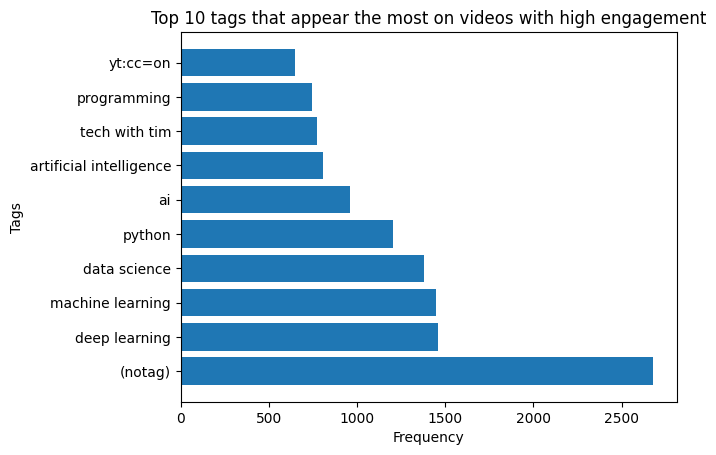

In [7]:
plt.barh(sorted_high_tags['tag'].head(10),sorted_high_tags['frequency'].head(10))
plt.title('Top 10 tags that appear the most on videos with high engagement')
plt.xlabel('Frequency')
plt.ylabel('Tags');

- `Comment`: So, as we can see, trends often show that not using tags, or opting for a minimalistic approach, can be a strategy to attract attention.
On the other hand, tags related to AI, Machine Learning, Deep Learning, Data Science, or general machine science topics tend to draw a lot of interest. The common characteristics of these tags are that they all seem concise and complete.

### **Question 3:**  Is there a particular time of the day, day of the week, or month when videos tend to get more views or engagement?

**Answering this question will:** by determining which times of the day, week, or month your video is most likely to attract the most viewers, you can optimize the time you air or publish your content. This increases the chances of your video being shown to a large audience and can generate positive engagement.

**How we answer this question:** we will use the columns `hour`, `day_of_week`, `month`, `viewCount`, `likeCount`, `commentCount`    

##### Preprocessing

In [8]:
interaction_df = video_df[['hour', 'day_of_week', 'month', 'viewCount', 'likeCount', 'commentCount']]

interaction_df['day_of_week'] = interaction_df['day_of_week'].apply(lambda x: calendar.day_name[x])
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
interaction_df['day_of_week'] = pd.Categorical(interaction_df['day_of_week'], categories=day_order, ordered=True)

interaction_df['total_interaction'] = interaction_df['viewCount'] + interaction_df['likeCount'] + interaction_df['commentCount']
interaction_df['like_comment_total'] = interaction_df['likeCount'] + interaction_df['commentCount']
interaction_df['view_only'] = interaction_df['total_interaction'] - interaction_df['like_comment_total']

##### Step 1: Analysis of Views, Likes and Comments time of the day and day of the week

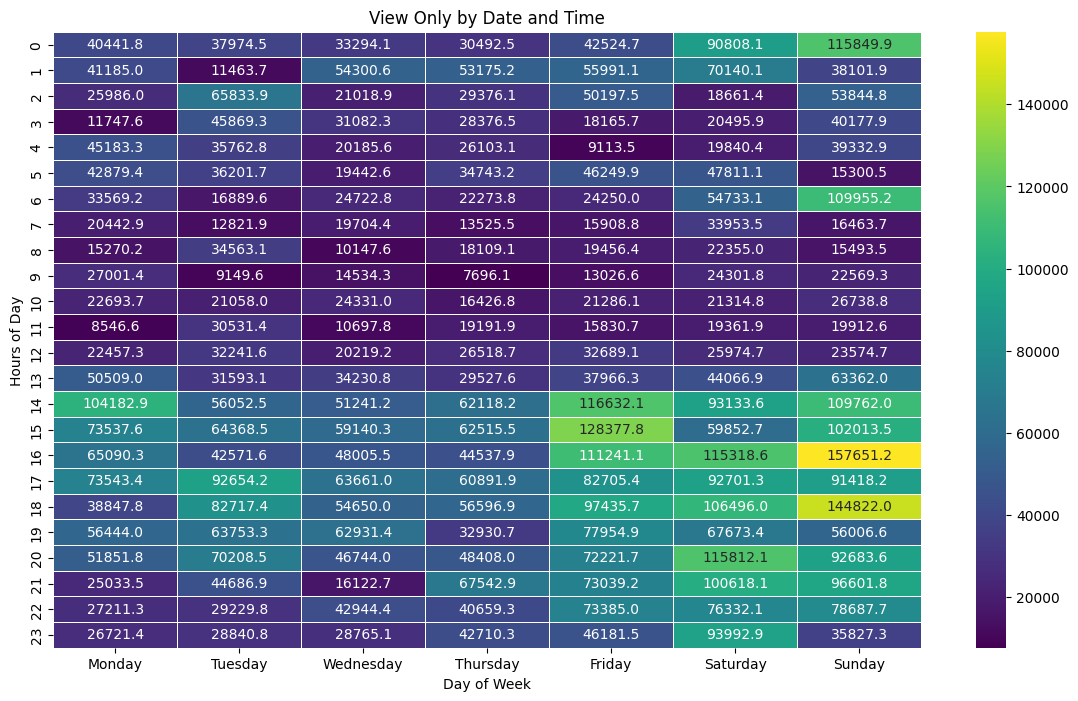

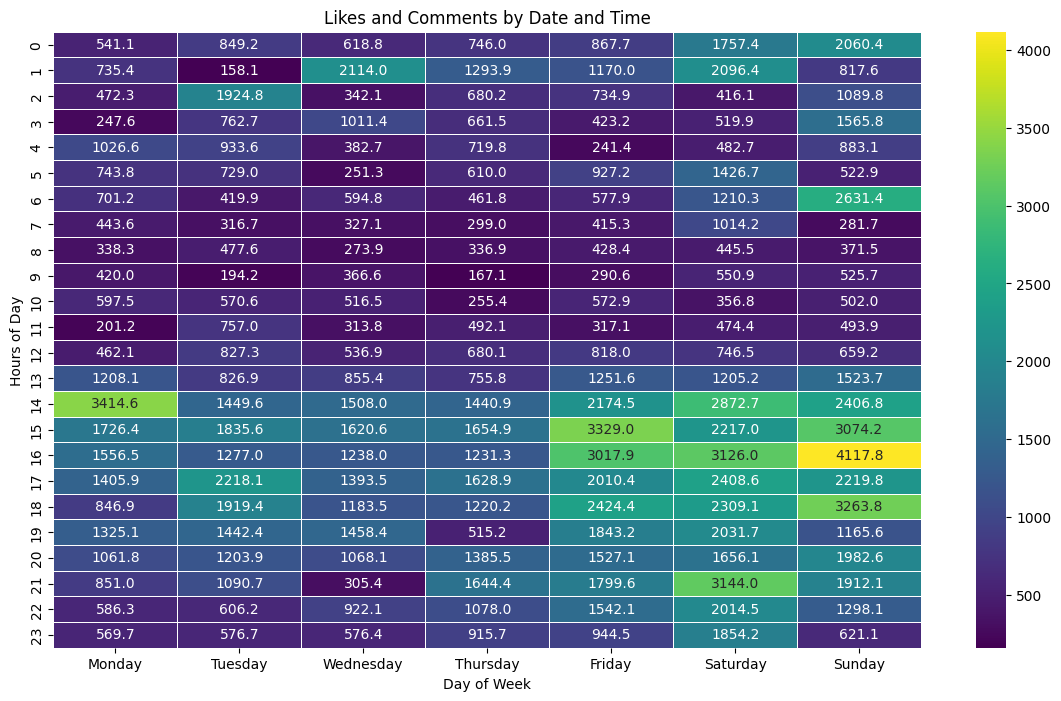

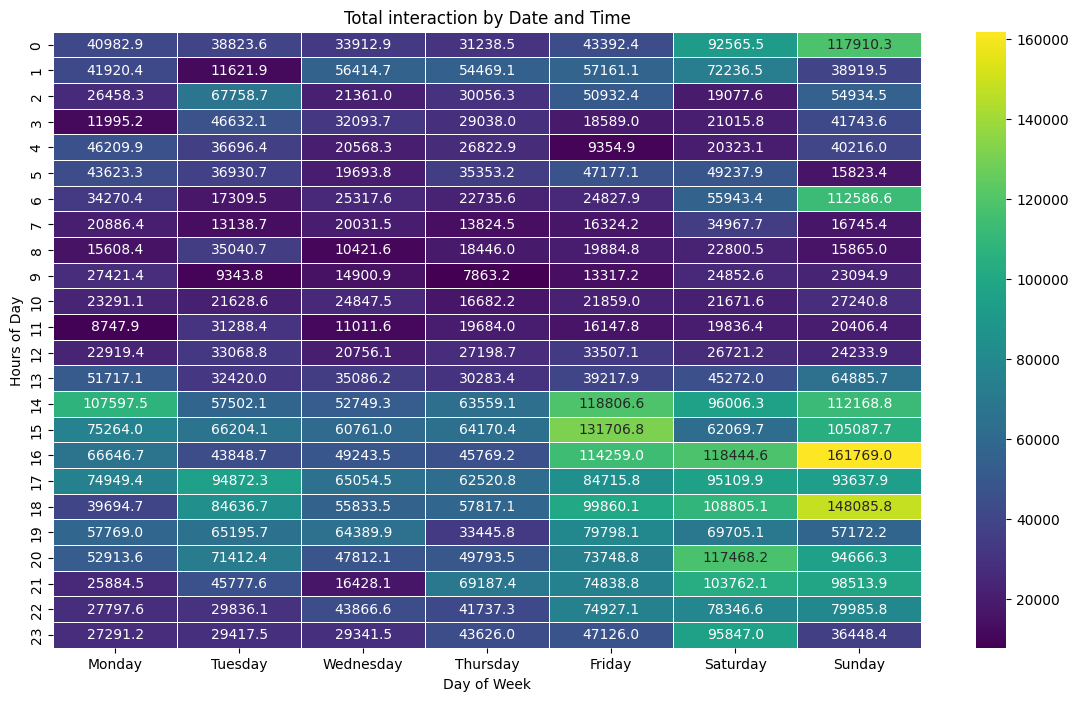

In [9]:
plt.figure(figsize=(14, 8))
view_only = interaction_df.pivot_table(index='hour', columns='day_of_week', values='view_only', aggfunc='mean')
sns.heatmap(view_only, cmap='viridis', annot=True, fmt=".1f", linewidths=.5)
plt.title('View Only by Date and Time')
plt.xlabel('Day of Week')
plt.ylabel('Hours of Day')
plt.show()

plt.figure(figsize=(14, 8))
like_comment_total = interaction_df.pivot_table(index='hour', columns='day_of_week', values='like_comment_total', aggfunc='mean')
sns.heatmap(like_comment_total, cmap='viridis', annot=True, fmt=".1f", linewidths=.5)
plt.title('Likes and Comments by Date and Time')
plt.xlabel('Day of Week')
plt.ylabel('Hours of Day')
plt.show()

plt.figure(figsize=(14, 8))
total_interaction_total = interaction_df.pivot_table(index='hour', columns='day_of_week', values='total_interaction', aggfunc='mean')
sns.heatmap(total_interaction_total, cmap='viridis', annot=True, fmt=".1f", linewidths=.5)
plt.title('Total interaction by Date and Time')
plt.xlabel('Day of Week')
plt.ylabel('Hours of Day')
plt.show()

- As for `views`, the more views there are on the weekend, especially from 2pm to 10pm during the day. The time period from 2pm to 6pm on Friday, Saturday and Sunday is the time when views are highest, the highest being 4pm on Sunday. The time period from Saturday evening to Sunday morning and Monday at 2:00 p.m. receives quite a high number of views.
- As for `likes and comments`, just like views, the closer to the weekend, the more interactions, especially from 2pm - 6pm during the day. The number of interactions between 2pm and 6pm on Friday, Saturday and Sunday has the highest number of interactions during the week, the highest is 4pm on Sunday.
- Looking at the overall views and interactions, we see that videos published from 2:00 p.m. to 6:00 p.m. will have the highest views and interactions during the day and on weekends, especially `Fridays, Saturday and Sunday` will receive the highest views and interactions, especially `4pm on Sunday`

##### Step 2: Analysis of Views, Likes and Comments by Month

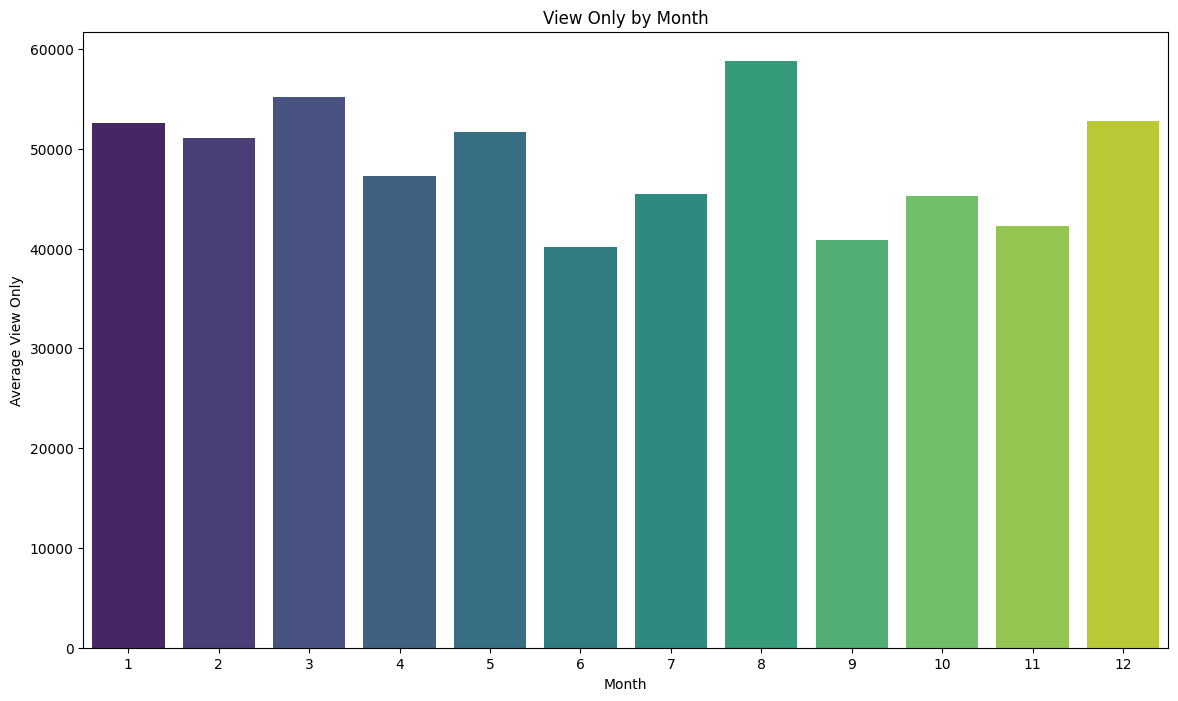

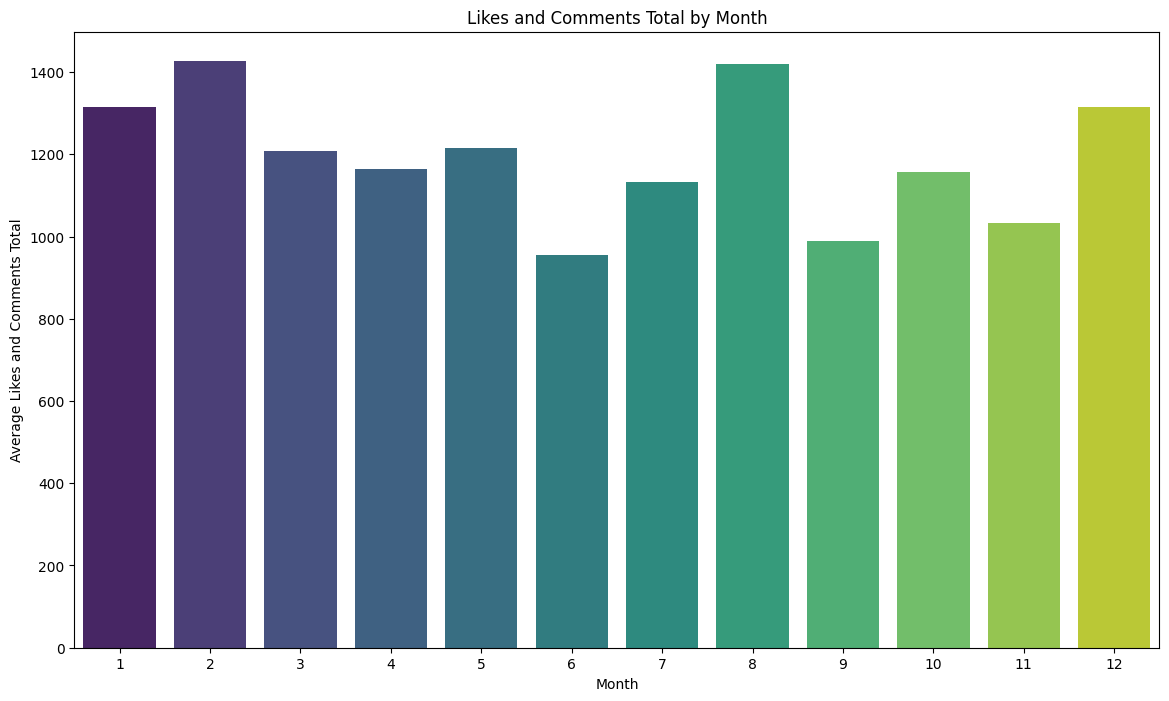

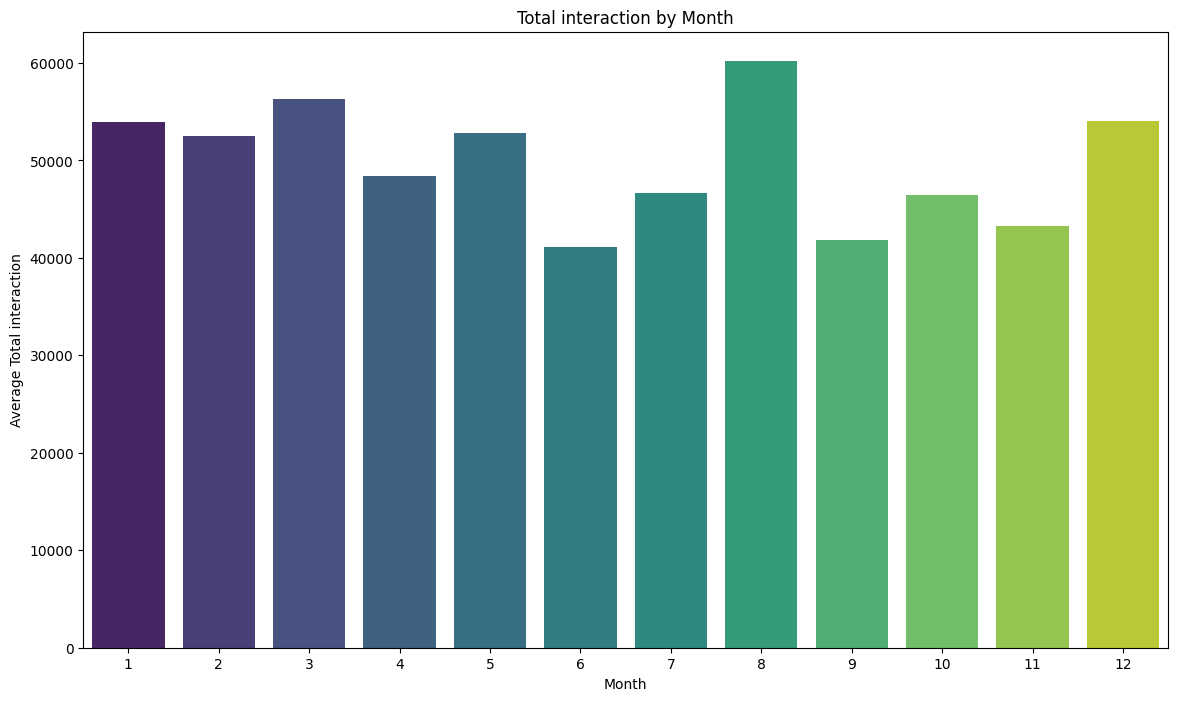

In [10]:
plt.figure(figsize=(14, 8))
view_only_month = interaction_df.pivot_table(index='month', values='view_only', aggfunc='mean')
sns.barplot(x=view_only_month.index, y='view_only', data=view_only_month, palette='viridis')
plt.title('View Only by Month')
plt.xlabel('Month')
plt.ylabel('Average View Only')
plt.show()

plt.figure(figsize=(14, 8))
like_comment_total_month = interaction_df.pivot_table(index='month', values='like_comment_total', aggfunc='mean')
sns.barplot(x=like_comment_total_month.index, y='like_comment_total', data=like_comment_total_month, palette='viridis')
plt.title('Likes and Comments Total by Month')
plt.xlabel('Month')
plt.ylabel('Average Likes and Comments Total')
plt.show()

plt.figure(figsize=(14, 8))
total_interaction_total_month = interaction_df.pivot_table(index='month', values='total_interaction', aggfunc='mean')
sns.barplot(x=total_interaction_total_month.index, y='total_interaction', data=total_interaction_total_month, palette='viridis')
plt.title('Total interaction by Month')
plt.xlabel('Month')
plt.ylabel('Average Total interaction')
plt.show()

- As for `views`, there are significant variations between months, `August` recorded the highest views while `June` had the lowest views.
- As for `likes and comments`, `February and August` had the most interactions of the year, `June` continued to be the lowest
- Overall in terms of both `views and interactions`, videos released in `August` will have the highest views, likes and comments. The opposite is true for `June` and `September`

### **Question 4:** How does caption affect views and interactions (likes, comments)?

**Answering this question will:** provides insights into how captions can impact video performance on the platform.

**How we answer this question:** we will use the columns `viewCount`, `likeCount`, `commentCount`, `caption` to calculate the correlation matrix

##### Step 1: Calculate the correlation matrix

In [11]:
correlation_matrix = video_df[['viewCount', 'likeCount', 'commentCount', 'caption']].corr()
correlation_matrix

,viewCount,likeCount,commentCount,caption
viewCount,1.000000,0.869915,0.723999,0.117834
likeCount,0.869915,1.000000,0.700103,0.128734
commentCount,0.723999,0.700103,1.000000,0.105745
caption,0.117834,0.128734,0.105745,1.000000


##### Step 2: Display the correlation matrix using a HeatMap chart

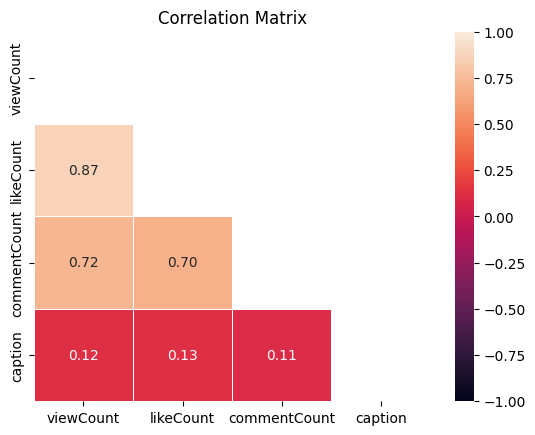

In [12]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, mask=mask, fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

- `viewCount` and `caption`: The correlation coefficient is 0.12, which found a very low degree of compatibility between captions and views. Captions have no effect on views.
- `likeCount` and `caption`: The correlation coefficient is 0.13, similar to views, captions do not have a large impact on likes.
- `commentCount` and `caption`: The correlation coefficient is 0.105745, a low correlation level, showing that caption do not affect the number of comments much.
- Overall, it seems like captions don't have as much of an impact on views and engagement compared to other factors like likes and comments.

### **Question 5:** What words are commonly used in video titles?

**Answering this question will:** It helps us identify which words in the title attract many viewers and are commonly used. We can change the video title to increase viewership.

**How we answer this question:** Calculate the number of occurrences of each word and remove some words that do not have much meaning in the title

Step 1: Convert words and eliminate words that have little meaning

In [13]:
stop = set(stopwords.words('english'))
stop.update(['&', ',', '-', '|'])

title = video_df['title'].str.split()
title = title.explode()

words = np.array([w.upper() for w in title if w.lower() not in stop])

Step 2: Calculate the number of each word

In [14]:
number_of_words = nltk.FreqDist(words)
mostcommon = number_of_words.most_common(10)

words_str = ' '.join(words)

Step 3: Draw detailed chart

Text(0.5, 1.0, 'Top 10 most commonly used words')

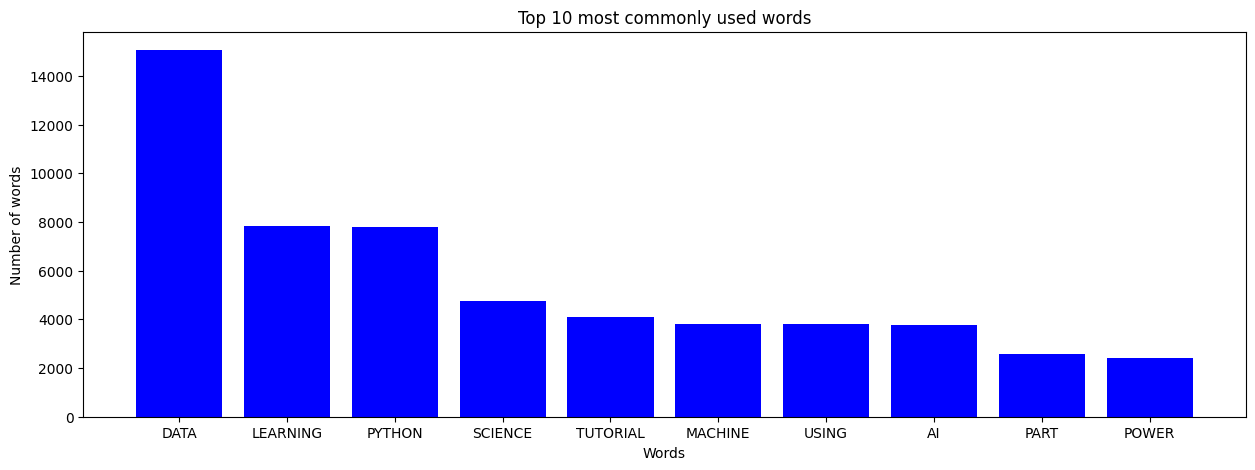

In [15]:
plt.figure(figsize=(15, 5))
plt.bar([t[0] for t in mostcommon], [t[1] for t in mostcommon], color='blue')

plt.xlabel('Words')
plt.ylabel('Number of words')
plt.title('Top 10 most commonly used words')

Step 4: Present visually using Word Cloud

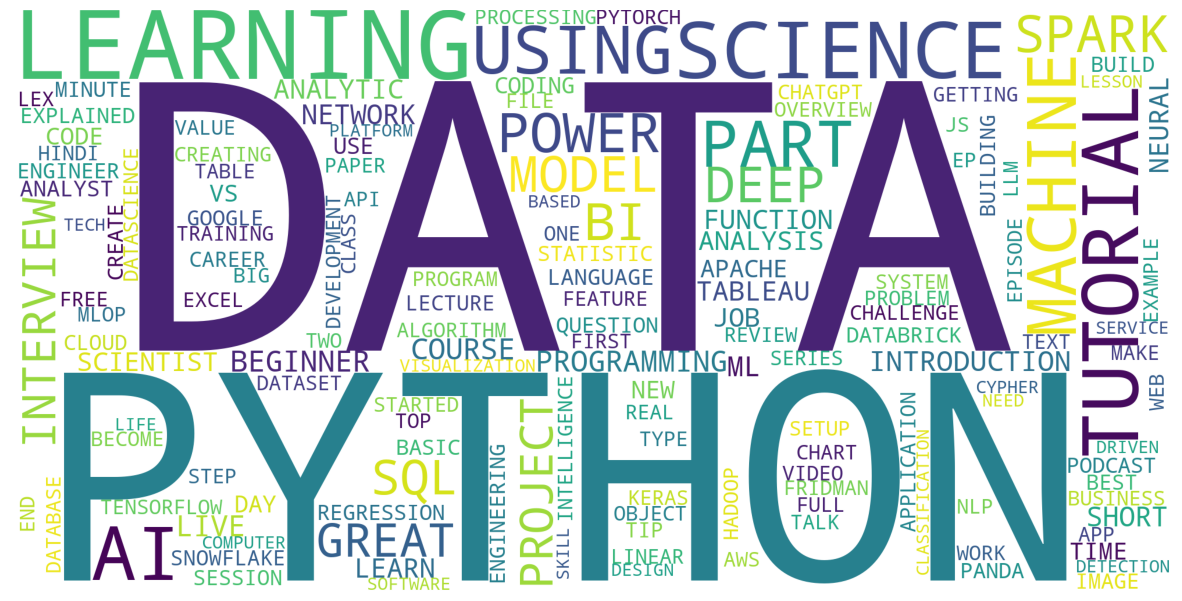

In [16]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='white', max_words=150, min_word_length=2,
                      colormap='viridis', collocations=False).generate(words_str)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud) 
plt.axis("off");

* The most common words are all related to data
* Most of the words in the top 10 are used roughly the same number of times
* No meaningless words or incorrect content

### **Question 6:** How has user interest in videos with data science content changed over the years?

**Answering this question will:** It helps us know the level of viewer interest and predict future viewership.

**How we answer this question:** Calculate the total views of all videos over each quarter of the year.

Preprocessing

In [17]:
video_df["publishedAt"] = pd.to_datetime(video_df["publishedAt"])
filtered_data = video_df.loc[video_df["publishedAt"].dt.year != 2023, ["publishedAt", "viewCount"]]
filtered_data.index = filtered_data.index - 1

Step 1: Divide video publishing time into quarters of the year and calculate views for each quarter

In [18]:
list_of_years = np.unique(video_df['publishedAt'].dt.year)

quarters = (filtered_data['publishedAt'].dt.month - 1) // 3 + 1
list_of_quarters = (filtered_data['publishedAt'].dt.year - 2006) * 4 + quarters

distribution = np.bincount(list_of_quarters, weights=filtered_data['viewCount'])
distribution = distribution[1:]

Step 2: Draw a line graph to represent

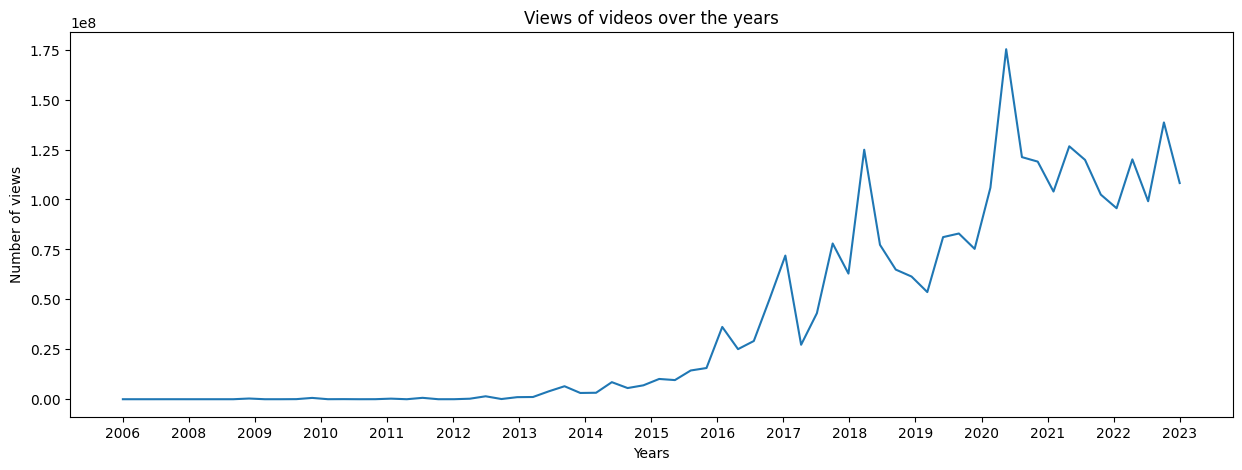

In [19]:
fig = plt.figure(figsize = (15, 5))
plt.plot(distribution)

plt.xticks(np.linspace(0, 67, 17), list_of_years, ha="center")

plt.xlabel("Years")
plt.ylabel("Number of views")
plt.title("Views of videos over the years")
plt.show()

* From 2006 to present, the number of users interested in data has tended to increase
* However, there is a large difference between years
* There is an unstable increase and decrease in views between years